In [4]:
!pip install pykalman
!pip install ffn
!pip install arbitragelab

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.6/251.6 kB 4.2 MB/s eta 0:00:00
  Attempting uninstall: decorator
    Found existing installation: decorator 4.4.2
    Uninstalling decorator-4.4.2:
      Successfully uninstalled decorator-4.4.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.
moviepy 1.0.3 requires decorator<5.0,>=4.0.2, but you have decorator 5.1.1 which is incompatible.


ERROR: Operation cancelled by user


In [1]:
import numpy as np
import pandas as pd
import matplotlib
from pykalman import KalmanFilter
from datetime import datetime
from numpy import log, polyfit, sqrt, std, subtract
import statsmodels.tsa.stattools as ts
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import ffn
import warnings
warnings.filterwarnings('ignore')
pd.core.common.is_list_like = pd.api.types.is_list_like
from pandas_datareader import data as pdr
import datetime
import yfinance as yf


pdr.get_data_yahoo = pdr.get_data_yahoo
start=datetime.datetime(2010,1,1)
end=datetime.datetime(2019,1,1)
tickers = ['AAPL', 'ADBE', 'ORCL', 'EBAY', 'MSFT', 'QCOM', 'HPQ', 'JNPR', 'AMD', 'IBM', 'SPY']
data=yf.download(tickers,start,end)['Close']
data.tail()
result = sm.tsa.stattools.coint(data['ADBE'],data['MSFT']) #Here we are directly using an in-built implementation of co-integration

pvalue = result[1]
print(pvalue)

[*********************100%***********************]  11 of 11 completed


0.011581363102776309


Modelling the realtionship between stocks using a kalman filter


In [2]:
price_ratio= data['ADBE']/data['MSFT']

def KalmanFilterAverage(x):
    # Creating a Kalman Filter
    from pykalman import KalmanFilter
    kf = KalmanFilter(transition_matrices = [1],
                      observation_matrices = [1],
                      initial_state_mean = 0,
                      initial_state_covariance = 1,
                      observation_covariance=1,
                      transition_covariance=.01)

    #Getting a rolling mean
    state_means, _ = kf.filter(x.values)
    state_means = pd.Series(state_means.flatten(), index=x.index)
    return state_means

def Kalman_regression(x,y):
    delta = 1e-3

    trans_cov = delta / (1 - delta) * np.eye(2) # How much random walk wiggles
    obs_mat = np.expand_dims(np.vstack([[x], [np.ones(len(x))]]).T, axis=1)

    kf = KalmanFilter(n_dim_obs=1, n_dim_state=2, # y is 1-dimensional, (alpha, beta) is 2-dimensional
                      initial_state_mean=[0,0],
                      initial_state_covariance=np.ones((2, 2)),
                      transition_matrices=np.eye(2),
                      observation_matrices=obs_mat,
                      observation_covariance=2,
                      transition_covariance=trans_cov)

    # Use the observations y to get running estimates and errors for the state parameters
    state_means, state_covs = kf.filter(y.values)

    return state_means

  #Here x is stock used for hedging while y is the stock we are trying to hedge
def half_life(spread):
    spread_lag = spread.shift(1)
    spread_lag.iloc[0] = spread_lag.iloc[1]

    spread_ret = spread - spread_lag
    spread_ret.iloc[0] = spread_ret.iloc[1]

    spread_lag2 = sm.add_constant(spread_lag)

    model = sm.OLS(spread_ret,spread_lag2)
    res = model.fit()
    halflife = int(round(-np.log(2) / res.params[1],0))



    if halflife <= 0:
        halflife = 1

    return halflife

Kalman_regression(data['ADBE'],data['MSFT'])






array([[0.81143068, 0.81143068],
       [0.80409106, 0.80705367],
       [0.79975459, 0.80578211],
       ...,
       [0.43887812, 2.38580883],
       [0.43921159, 2.38583699],
       [0.43843129, 2.38593252]])

Calculating spread and generating trading signals


1042.131429961469


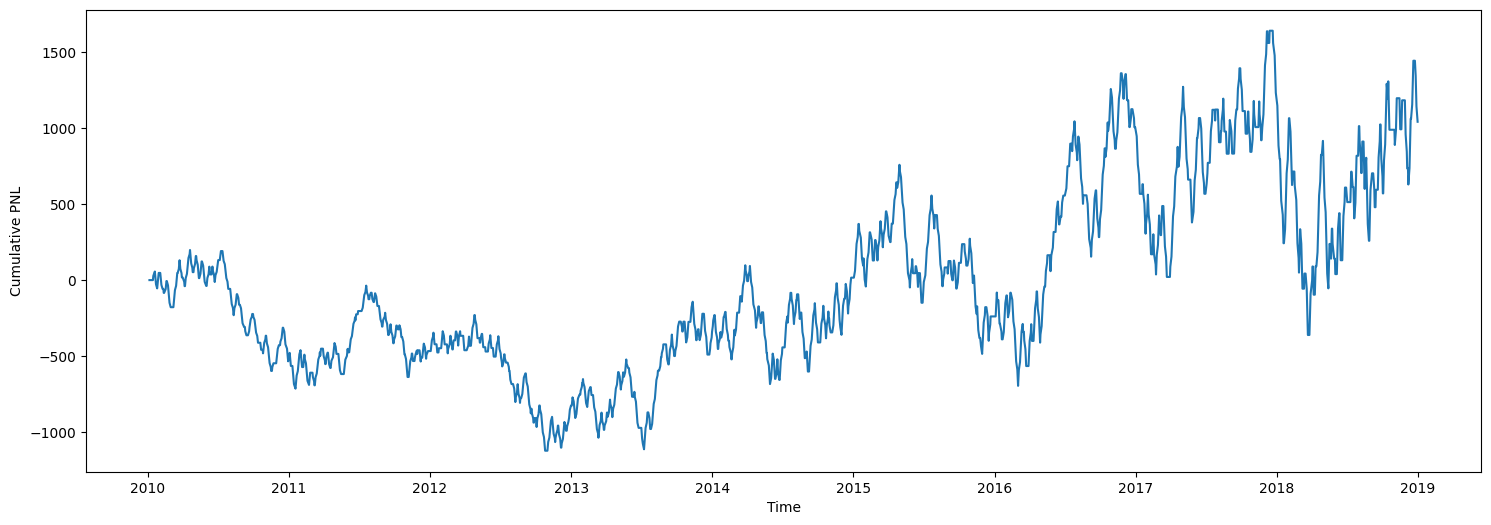

In [3]:

def pair_trade(x,y,i,transaction_cost=0.01):
  data_1=pd.DataFrame({'y':y,'x':x})
  state_means = Kalman_regression(KalmanFilterAverage(x),KalmanFilterAverage(y))
  data_1['hedge_ratio']=-state_means[:,0]


  data_1['spread']=data_1.y+(data_1.x*data_1.hedge_ratio)




  halflife=half_life(data_1['spread'])


  meanspread=data_1.spread.rolling(window=halflife).mean()

  stdspread=data_1.spread.rolling(window=halflife).std()



  data_1['z_score_spread']=(data_1.spread-meanspread)/stdspread


  trade_score=i
  exitscore=0
   #for long trades
  data_1['long_entry']=((data_1.z_score_spread<-(transaction_cost+trade_score)) & (data_1.z_score_spread.shift(1)>-(transaction_cost+trade_score)))
  data_1['long_exit']=((data_1.z_score_spread > -(transaction_cost+exitscore))&(data_1.z_score_spread.shift(1)< -(transaction_cost+exitscore)))
  data_1['total_long']=np.nan

  data_1.loc[data_1.long_entry,'total_long']=1
  data_1.loc[data_1.long_exit,'total_long']=0
  data_1['total_long'][0]=0
  data_1['total_long']=data_1['total_long'].fillna(method='pad')

  #for short trades
  data_1['short_entry']=((data_1.z_score_spread>(trade_score-transaction_cost)))
  data_1['short_exit']=((data_1.z_score_spread <(exitscore-transaction_cost)))
  data_1.loc[data_1['short_entry'],'total_short']=-1
  data_1.loc[data_1['short_exit'],'total_short']=0
  data_1['total_short'][0]=0
  data_1['total_short']=data_1['total_short'].fillna(method='pad')


  data_1['units']=data_1['total_long']+data_1['total_short']



  data_1['spread_change']=data_1['spread']-data_1['spread'].shift(1)/data_1.y+(data_1.x*data_1.hedge_ratio)


  data_1['returns']=data_1['spread_change']*data_1['units'].shift(1)
  data_1['returns'] = data_1['returns'] - abs(data_1['units'].diff()) * transaction_cost

  data_1['cum_returns']=data_1['returns'].cumsum()
  data_1['cum_returns']=data_1.cum_returns+1
  return data_1['cum_returns']






netpnl=pair_trade(data['ADBE'],data['MSFT'],1)
print(netpnl[-1])
plt.figure(figsize=(18,6))
plt.plot(netpnl,label='Cumulative PNL')
plt.xlabel('Time')
plt.ylabel('Cumulative PNL')

plt.show()


Finding the ideal trade score to short or long the stock

5980.96256691284
5980.96256691284


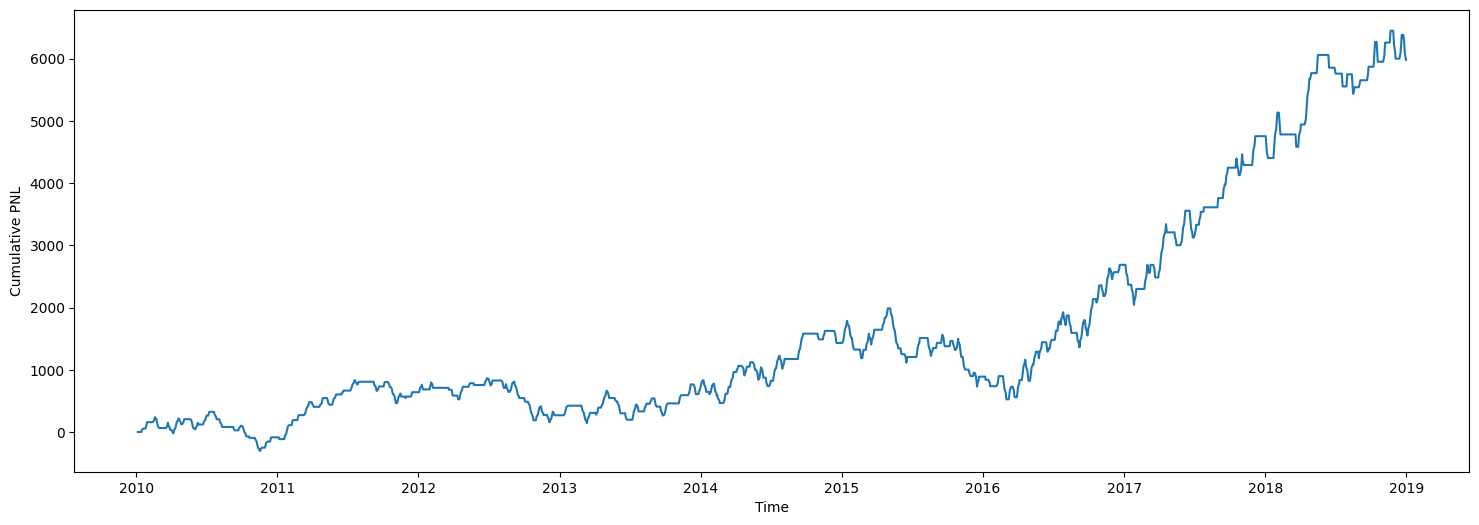

In [ ]:
lowestrange=0.5
highest_range=2
t=0


netprofit=[]
for i in np.arange(lowestrange,highest_range,0.1):
  netpnl=pair_trade(data['ADBE'],data['MSFT'],i)

  if(netpnl[-1]>5980):
    t=i

  netprofit.append(netpnl[-1])
print(max(netprofit))
maxpnl=pair_trade(data['ADBE'],data['MSFT'],t)
print(maxpnl[-1])
plt.figure(figsize=(18,6))
plt.plot(maxpnl,label='Cumulative PNL')
plt.xlabel('Time')
plt.ylabel('Cumulative PNL')

plt.show()

Finding different cointegerated pairs to test the Kalman filter
:

In [4]:
"""Finding cointegerated pairs"""
p_values=[]
for i in range(0,len(tickers)):
    for j in range(i+1,len(tickers)):
      result = sm.tsa.stattools.coint(data[tickers[i]],data[tickers[j]])
      p_values.append((data[tickers[i]],data[tickers[j]],result[1]))
p_values.sort(key=lambda item:item[2])
print(p_values[0])
result = sm.tsa.stattools.coint(data['ORCL'],data['SPY'])
print(result[1])

(Date
2010-01-04    24.850000
2010-01-05    24.820000
2010-01-06    24.459999
2010-01-07    24.379999
2010-01-08    24.680000
                ...    
2018-12-24    42.689999
2018-12-26    44.590000
2018-12-27    44.970001
2018-12-28    44.820000
2018-12-31    45.150002
Name: ORCL, Length: 2264, dtype: float64, Date
2010-01-04    113.330002
2010-01-05    113.629997
2010-01-06    113.709999
2010-01-07    114.190002
2010-01-08    114.570000
                 ...    
2018-12-24    234.339996
2018-12-26    246.179993
2018-12-27    248.070007
2018-12-28    247.750000
2018-12-31    249.919998
Name: SPY, Length: 2264, dtype: float64, 0.0018231462469677421)
0.0018231462469677421


Using the Kalman filter pairs trading strategy on the stock pair ORCL and SPY


The entry trade score is 1.8999999999999997 and thet profits are 10446.462973586542 


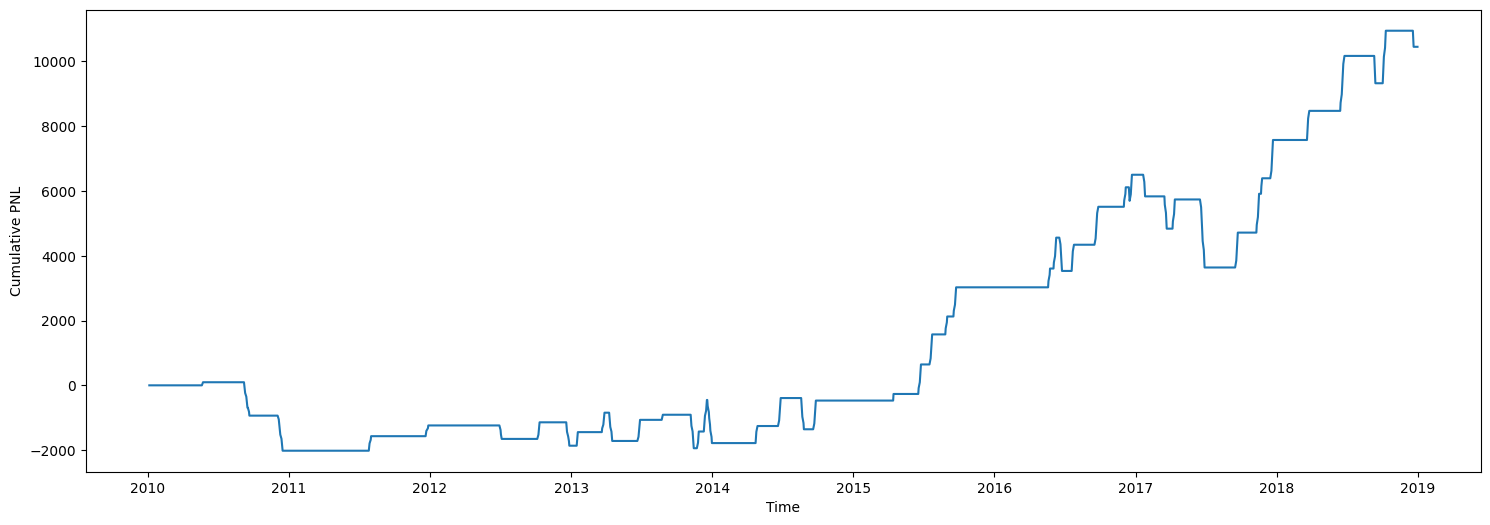

In [12]:
lowestrange=0.5
highest_range=2
m=0
trade_netpnl_pair=[]
profits=[]
for i in np.arange(lowestrange,highest_range,0.1):
  netpnl=pair_trade(data['ORCL'],data['SPY'],i)
  profits.append(netpnl[-1])

  trade_netpnl_pair.append((i,netpnl[-1]))
for t,profit in trade_netpnl_pair:
  if(profit==max(profits)):
    print(f'The entry trade score is {t} and thet profits are {profit} ')
    plt.figure(figsize=(18,6))
    plt.plot(pair_trade(data['ORCL'],data['SPY'],t),label='Cumulative PNL')
    plt.xlabel('Time')
    plt.ylabel('Cumulative PNL')

    plt.show()



